In [1]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from market_data.market_data import get_daily_stats
import os
%matplotlib inline

In [2]:
#sim = pd.read_csv('c:/temp/SIM_RESULTS_12_19_ENRICHED.csv')
FNAME = 'c:/temp/SIM_RESULTS_01_08'
if os.path.exists(f'{FNAME}_ENRICHED.csv'):
    print(f'Using cached file {FNAME}_ENRICHED.csv')
    sim = pd.read_csv(f'{FNAME}_ENRICHED.csv')
    sim['date']=pd.to_datetime(sim['date'])
    #Impute missing values with averages ( not great but not terrible )
    for col in 'ar_vol ar_beta ADV ADVD'.split():
        sim[col].fillna((sim[col].mean()), inplace=True)
    print(sim.columns)

else:
    #Read results of the simulation. Add some columns
    #sim = pd.read_csv('c:/temp/SIM_RESULTS_12_8.csv')
    print(f'Reading basic file {FNAME}.csv')
    sim = pd.read_csv(f'{FNAME}.csv')
    sim['date']=pd.to_datetime(sim['date'])
    daily_stats = get_daily_stats(sim)
    sim=sim.merge(daily_stats,on=['sym','date'],how='left')
    sim['ew_return']=sim.c2cdn*np.sign(sim.predicted_c2cdn) ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
    sim['ewo_return']=sim.o2cdn*np.sign(sim.predicted_c2cdn)  ##c2c return assuming we go long whenever prediced_c2cdn is positive and short otherwise
                                                              ## more realistic -assumes we open MOO positions based on prev close pricing
    sim['P'] = sim.model_order.apply(lambda x: eval(x)[0])
    sim['Q'] = sim.model_order.apply(lambda x: eval(x)[-1])
    sim['predicted_tstat'] = sim.predicted_c2cdn.abs()/sim.predicted_se ##Certainty of our prediction - unsigned
    sim['abs_predicted_c2cdn'] = sim.predicted_c2cdn.abs() ##Strength of our prediction - unsigned
    sim['date']=pd.to_datetime(sim['date'])
    #Impute missing values with averages ( not great but not terrible )
    for col in 'ar_vol ar_beta ADV ADVD'.split():
        sim[col].fillna((sim[col].mean()), inplace=True)
    sim.to_csv(f'{FNAME}_ENRICHED.csv')
print('SHAPE', sim.shape)
print('COLUMNS', sim.columns)

sim.head(2)


Using cached file c:/temp/SIM_RESULTS_01_08_ENRICHED.csv
Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'sym', 'adjusted_close', 'o2c',
       'volume', 'prev_c2c', 'c2c', 'prev_volume', 'benchmark', 'c2cb', 'o2cb',
       'prev_c2cb', 'c2cdn', 'prev_c2cdn', 'o2cdn', 'predicted_c2cdn',
       'predicted_se', 'model_order', 'ar_vol', 'ar_beta', 'ADV', 'ADVD',
       'ew_return', 'ewo_return', 'P', 'Q', 'predicted_tstat',
       'abs_predicted_c2cdn'],
      dtype='object')
SHAPE (988770, 30)
COLUMNS Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'sym', 'adjusted_close', 'o2c',
       'volume', 'prev_c2c', 'c2c', 'prev_volume', 'benchmark', 'c2cb', 'o2cb',
       'prev_c2cb', 'c2cdn', 'prev_c2cdn', 'o2cdn', 'predicted_c2cdn',
       'predicted_se', 'model_order', 'ar_vol', 'ar_beta', 'ADV', 'ADVD',
       'ew_return', 'ewo_return', 'P', 'Q', 'predicted_tstat',
       'abs_predicted_c2cdn'],
      dtype='object')


,Unnamed: 0.1,Unnamed: 0,date,sym,adjusted_close,o2c,volume,prev_c2c,c2c,prev_volume,...,ar_vol,ar_beta,ADV,ADVD,ew_return,ewo_return,P,Q,predicted_tstat,abs_predicted_c2cdn
0,0,0,2007-07-02,ABBC,9.64,-0.011282,242400.0,-0.005208,0.009424,638700.0,...,0.018646,0.839000,49440.0,511699.7,-0.000383,0.01738,1,1,0.140495,0.001681
1,1,1,2007-07-03,ABBC,9.69,-0.008188,126300.0,0.009424,0.005187,242400.0,...,0.018601,0.837517,49600.0,529947.4,-0.001564,0.00924,1,1,0.247221,0.002958


In [3]:
#assign substrategy - momentul/rev l/s
sim['strategy']='NA'
sim.loc[ (np.sign(sim.prev_c2cdn)==1) & (np.sign(sim.predicted_c2cdn)==1),'strategy'] = 'ML' #Momentum long
sim.loc[(np.sign(sim.prev_c2cdn)==-1) & (np.sign(sim.predicted_c2cdn)==-1),'strategy'] = 'MS' #Momentum Short
sim.loc[(np.sign(sim.prev_c2cdn)==-1) & (np.sign(sim.predicted_c2cdn)==1),'strategy'] = 'RL' #Reversion long
sim.loc[(np.sign(sim.prev_c2cdn)==1) & (np.sign(sim.predicted_c2cdn)==-1),'strategy'] = 'RS' #Reversion Short



In [4]:
sim['activity'] = sim.prev_volume/sim.ADV

In [5]:
#Add quantiles for certain continuous varibales
q= list(np.arange(0,1.,.1))
for c in  "predicted_tstat ar_beta ar_vol ADV ADVD abs_predicted_c2cdn activity".split():    
    ##quantiles = sim[c].quantile(q+[1]).values
    labels = [str(int(10*s)) for s in q]
    sim[f'{c}_q']= pd.qcut( sim[c],q+[1],retbins=False,labels=labels)

    ##print the resulting cuts
    #print(sim.groupby(f'{c}_q').agg( { c:[np.mean,np.min, np.max,len] } ))

In [6]:
with pd.option_context('display.max_rows', 100):
    temps=sim.groupby([sim.model_order,sim.strategy])['ew_return'].agg([np.mean,np.std,len])
    display(temps[temps.len>10000])


mean       std     len
model_order strategy                            
(1, 0, 1)   ML       -0.000033  0.025705  177987
            MS        0.000352  0.027822  175888
            RL        0.000647  0.025003  276722
            RS        0.000607  0.024857  257193
(1, 0, 2)   RL        0.001110  0.027466   17304
            RS        0.001215  0.023339   15756

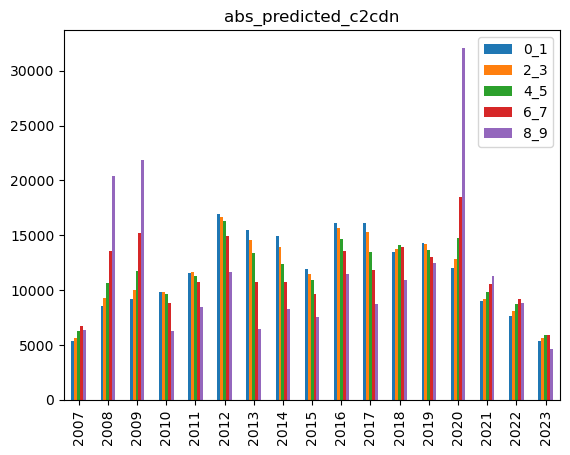

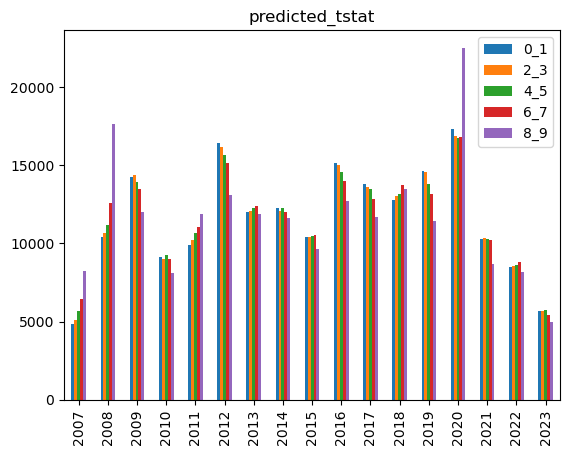

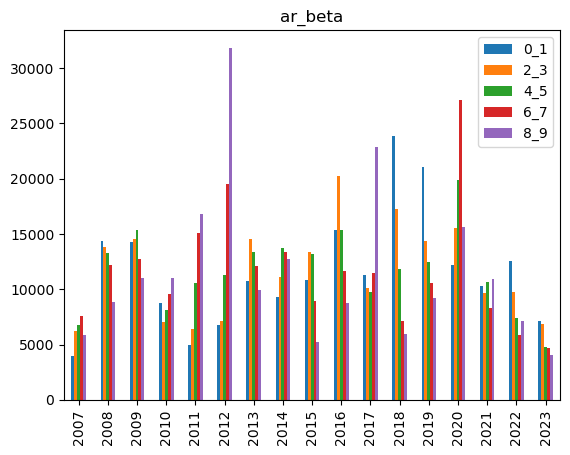

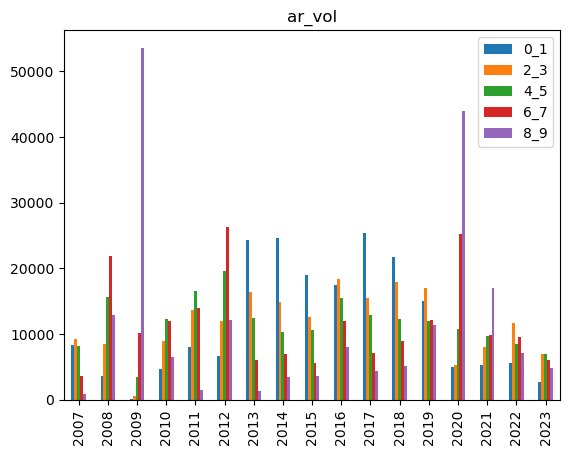

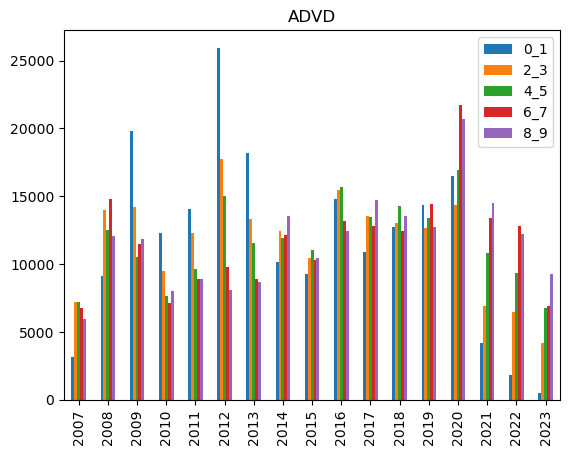

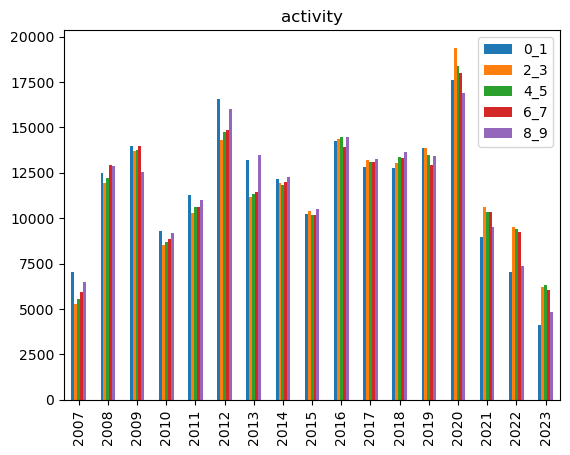

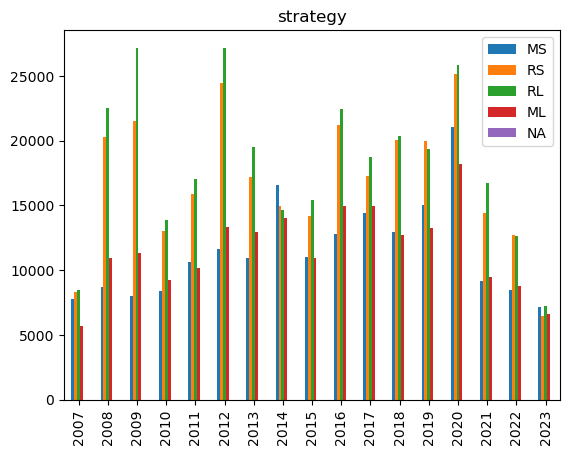

In [7]:
#Demographics by year
for col in  "abs_predicted_c2cdn predicted_tstat ar_beta ar_vol ADVD activity".split():    
    dates = sorted(sim.date.unique())
    df = pd.DataFrame(index=dates)
    groups = [[0,1],[2,3],[4,5],[6,7],[8,9]]
    for g in groups:
            df[ f'{g[0]}_{g[-1]}' ] = sim[ sim[col+'_q'].isin([str(x) for x in g])].groupby('date')['sym'].count()
    df.fillna(0,inplace=True)
    df = df.groupby(df.index.year).sum()
    df.plot.bar(stacked=False,title=col)
    plt.show()
    
dates = sorted(sim.date.unique())
df = pd.DataFrame(index=dates)
for g in sim.strategy.unique():
    df[ g ] = sim[ sim.strategy == g].groupby('date')['sym'].count()
df.fillna(0,inplace=True)
df = df.groupby(df.index.year).sum()
df.plot.bar(stacked=False,title='strategy')
plt.show()

In [8]:
for col in  "abs_predicted_c2cdn predicted_tstat ar_beta ar_vol ADVD strategy activity".split():    
    qCol = col+'_q' if col != 'strategy' else col 
    stats=sim.groupby(qCol).agg({'ew_return':[np.mean,np.std,min,max],col: [np.min,np.max],
                                         'ewo_return': [np.mean]})
    with pd.option_context('display.float_format', '{:,.4f}'.format):
        print(f'{col} decile stats\n {stats}\n')


abs_predicted_c2cdn decile stats
                       ew_return                       abs_predicted_c2cdn   
                           mean    std     min    max                 min   
abs_predicted_c2cdn_q                                                       
0                        0.0000 0.0191 -0.3846 0.7716              0.0000  \
1                        0.0001 0.0198 -0.4363 0.8651              0.0005   
2                        0.0000 0.0196 -0.4492 0.7078              0.0010   
3                        0.0002 0.0205 -0.7837 0.6292              0.0016   
4                        0.0002 0.0221 -1.0665 1.3055              0.0022   
5                        0.0001 0.0224 -0.6127 0.4874              0.0029   
6                        0.0003 0.0243 -0.5107 1.0091              0.0038   
7                        0.0005 0.0266 -0.6088 0.7620              0.0050   
8                        0.0009 0.0308 -1.1352 1.1404              0.0068   
9                        0.0022 0.0434 -0.

In [9]:
features = ['predicted_c2cdn','predicted_se','P','Q','predicted_tstat','ar_vol','ar_beta','ADVD','strategy','activity']
X = sim[features]
Y = sim['ew_return']
ct = make_column_transformer( (OneHotEncoder(),['strategy']),remainder="passthrough")
rf = RandomForestRegressor(n_estimators=100,max_depth=4,verbose=True)
pipe = make_pipeline(ct,rf)
pipe.fit(X,Y)
#rf.fit(X,Y)
from sklearn.metrics import r2_score
print(f'R2 score {r2_score(Y, pipe.predict(X))} ') 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


R2 score 0.0037531004070624485 


<center> Feature Importance </center>

In [10]:
fn = ct.get_feature_names_out()
#fn = features
fi = rf.feature_importances_
fi_df = pd.DataFrame({'feature':fn,'importance':fi})
fi_df.sort_values('importance', ascending=False,inplace=True)
fi_df

,feature,importance
5,remainder__predicted_c2cdn,0.370364
9,remainder__predicted_tstat,0.134205
11,remainder__ar_beta,0.128722
10,remainder__ar_vol,0.117421
12,remainder__ADVD,0.100940
6,remainder__predicted_se,0.070389
13,remainder__activity,0.056959
4,onehotencoder__strategy_RS,0.006944
7,remainder__P,0.005228
1,onehotencoder__strategy_MS,0.003603


ALPHA(BPS) for predicted_tstat_q vs strategy


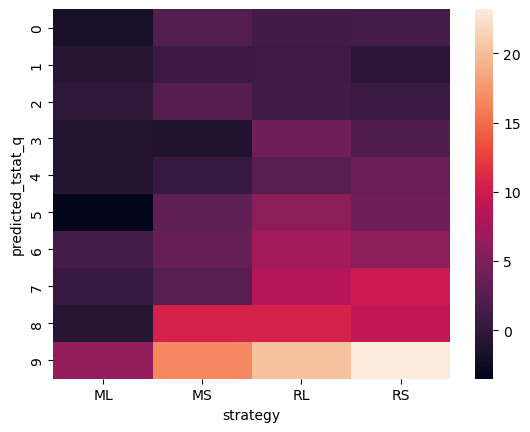

strategy             ML    MS    RL    RS
predicted_tstat_q                        
0                 -1.75  2.17  1.28  1.39
1                 -0.77  0.80  0.88 -0.40
2                 -0.18  2.52  1.00  0.62
3                 -1.07 -1.19  3.99  1.98
4                 -1.05  0.37  2.71  3.71
5                 -3.51  3.02  5.86  4.04
6                  1.41  3.49  7.30  5.87
7                  0.37  2.67  8.40  9.80
8                 -0.78 10.48 10.60  9.15
9                  6.33 16.58 20.18 23.21
COUNTS for predicted_tstat_q vs strategy
strategy              ML     MS  NA     RL     RS
predicted_tstat_q                                
0                  24279  24268  11  25283  25036
1                  23951  23020  10  26451  25445
2                  22772  21945   8  28026  26126
3                  21786  20806   7  29066  27212
4                  20641  19753   4  30692  27787
5                  19136  18388   3  32261  29089
6                  17604  17376   3  34023  29871
7    

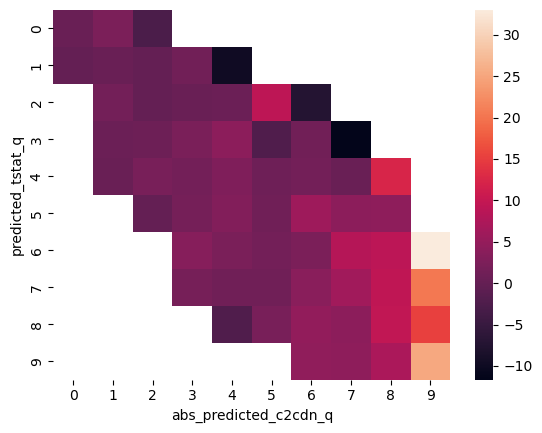

abs_predicted_c2cdn_q     0    1     2    3     4     5     6      7     8   
predicted_tstat_q                                                            
0                      0.49 2.42 -2.82  NaN   NaN   NaN   NaN    NaN   NaN  \
1                     -0.00 0.52 -0.11 1.41 -9.77   NaN   NaN    NaN   NaN   
2                       NaN 1.56 -0.03 0.44  0.73  9.14 -7.35    NaN   NaN   
3                       NaN 0.63  0.89 2.27  4.06 -2.26  1.31 -11.64   NaN   
4                       NaN 0.44  2.06 1.50  2.66  0.93  1.51   0.47 12.34   
5                       NaN  NaN -0.02 1.69  3.12  1.19  5.88   4.22  4.39   
6                       NaN  NaN   NaN 3.40  2.26  1.53  2.36   8.33  8.97   
7                       NaN  NaN   NaN 1.83  1.25  1.11  3.77   6.26  9.34   
8                       NaN  NaN   NaN  NaN -2.38  2.04  4.69   4.05  9.56   
9                       NaN  NaN   NaN  NaN   NaN   NaN  4.48   4.39  7.31   

abs_predicted_c2cdn_q     9  
predicted_tstat_q            
0  

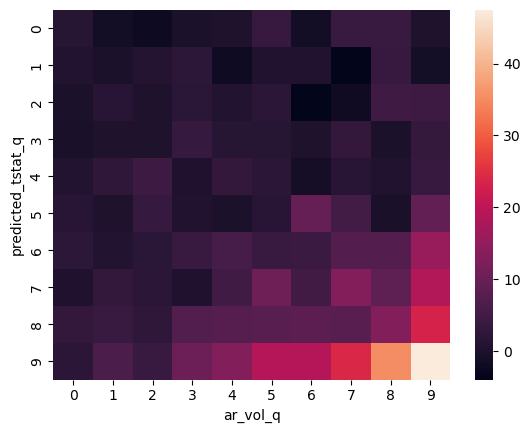

ar_vol_q              0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                  1.37 -1.50 -2.26 -0.19  0.24  3.67 -1.38  3.85  3.88  0.11
1                  0.79 -0.15  0.88  2.27 -2.10  0.54  0.55 -3.94  3.55 -1.30
2                 -0.28  1.52  0.23  1.86  0.77  1.98 -3.86 -1.73  4.57  4.36
3                 -0.39  0.12  0.27  3.42  1.41  1.40  0.10  2.92 -0.27  3.26
4                  0.72  2.38  4.48  0.42  3.02  1.89 -1.09  1.49  0.53  3.61
5                  1.53  0.21  3.36  0.57 -0.30  1.63  9.51  5.11 -0.51  8.93
6                  2.17  0.70  1.84  3.87  5.65  3.88  4.04  7.18  7.22 15.64
7                  0.46  2.94  2.08  0.45  4.75 10.47  5.07 13.18  8.51 18.63
8                  3.06  3.87  2.41  6.91  7.59  7.86  8.32  7.95 12.97 23.19
9                  1.89  6.14  3.74 10.24 13.05 18.81 18.78 24.12 35.34 47.45
COUNTS for predicted_tstat_q vs ar_vol_q
ar_vol_q               

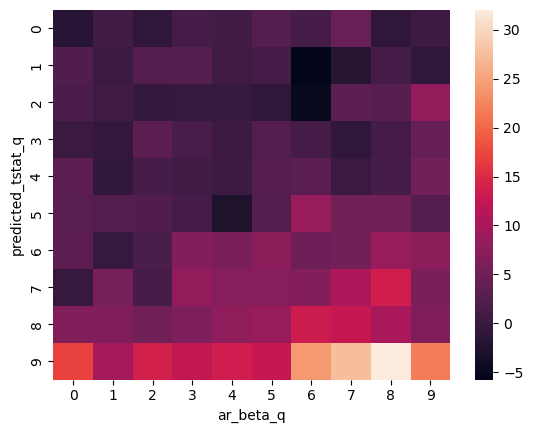

ar_beta_q             0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                 -1.70  0.66 -0.99  1.13  1.01  2.59  1.24  4.35 -0.96  0.42
1                  2.10  0.14  2.41  2.63  0.48  1.04 -5.76 -1.91  1.17 -1.11
2                  1.91  0.53 -0.53 -0.38 -0.18 -0.90 -4.95  3.15  2.76  8.04
3                  0.13 -0.71  3.34  1.49  0.22  2.49  1.06 -0.98  1.07  4.19
4                  3.29 -0.77  1.31  0.83  0.19  2.75  3.13  0.07  1.24  5.38
5                  2.94  2.26  2.19  1.14 -2.78  2.60  8.68  5.25  5.20  2.61
6                  3.36 -0.41  1.69  6.80  5.93  7.52  4.96  5.45  8.67  7.63
7                 -0.23  5.66  1.30  7.99  7.05  6.94  6.89 10.36 13.68  5.92
8                  6.58  6.42  5.21  6.26  7.92  8.58 13.16 12.62  9.95  6.39
9                 17.21  9.74 13.96 12.37 13.57 12.50 24.13 27.45 32.02 21.79
COUNTS for predicted_tstat_q vs ar_beta_q
ar_beta_q             

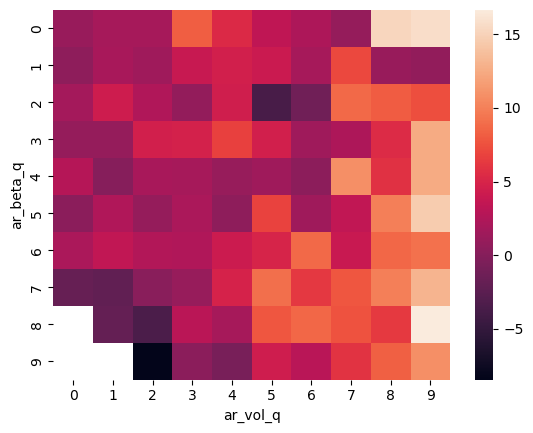

ar_vol_q      0     1     2    3     4     5     6     7     8     9
ar_beta_q                                                           
0          1.12  1.89  1.90 8.18  5.36  3.37  2.28  0.91 15.27 15.74
1          0.53  1.96  1.49 3.81  4.59  4.06  1.86  7.13  1.12  0.75
2          1.79  4.27  2.44 0.79  4.46 -3.72 -1.22  8.79  8.07  7.43
3          0.88  0.94  4.50 4.75  6.70  4.51  1.46  2.25  5.39 12.46
4          2.77  0.05  2.02 1.86  0.97  1.51  0.40 10.77  5.81 12.47
5          0.31  2.46  0.95 2.23  0.54  6.83  1.48  3.44  9.92 14.57
6          2.17  3.42  2.57 2.44  4.11  4.95  8.79  3.93  8.71  9.18
7         -1.86 -2.14  0.21 1.00  4.86  9.01  6.26  7.76  9.98 13.04
8           NaN -1.97 -3.45 3.08  1.93  7.75  8.65  7.62  6.30 16.65
9           NaN   NaN -8.45 0.36 -0.80  4.39  2.95  5.88  8.23 10.78
COUNTS for ar_beta_q vs ar_vol_q
ar_vol_q       0      1      2      3      4      5      6      7      8   
ar_beta_q                                                      

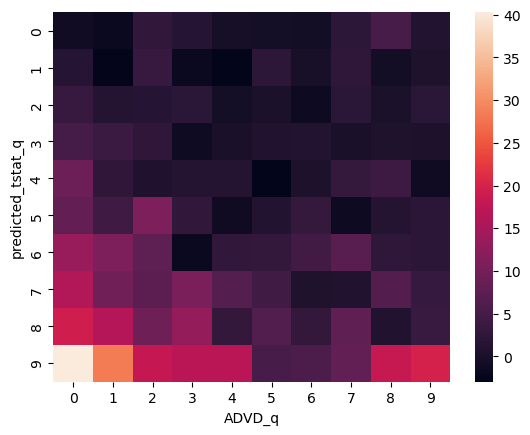

ADVD_q                0     1     2     3     4     5     6     7     8     9
predicted_tstat_q                                                            
0                 -1.06 -1.64  2.65  1.33 -0.34 -0.65 -0.90  2.23  5.21  0.92
1                  1.26 -2.73  3.36 -1.64 -2.98  2.10 -0.16  2.33 -0.78  0.50
2                  3.44  1.17  1.35  1.90 -0.67  0.21 -1.48  1.85  0.21  1.82
3                  4.94  3.73  2.54 -1.33 -0.10  0.80  1.07  0.01  0.56  0.37
4                  8.94  2.45  0.68  1.18  1.10 -2.87  0.38  3.00  4.10 -1.24
5                  8.03  4.21 10.85  2.72 -1.26  1.08  3.02 -1.52  1.20  1.94
6                 13.59 10.85  7.62 -1.68  2.71  2.82  4.60  6.85  2.40  2.06
7                 15.99  9.53  7.47 10.47  6.66  4.40  0.45  0.86  6.35  3.15
8                 19.18 16.19  9.07 13.21  2.79  6.29  2.85  7.72  0.91  3.58
9                 40.31 28.31 18.04 16.82 16.81  5.18  5.71  7.97 18.23 19.73
COUNTS for predicted_tstat_q vs ADVD_q
ADVD_q                 0 

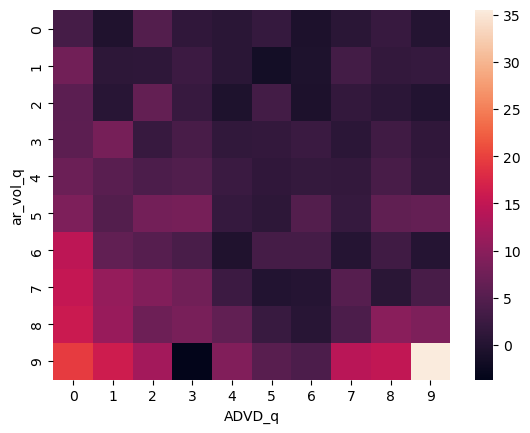

ADVD_q       0     1     2     3     4     5     6     7     8     9
ar_vol_q                                                            
0         3.49 -0.35  4.88  1.36  0.73  1.91 -0.72  0.69  2.08  0.08
1         7.74  0.93  1.06  2.51  0.75 -1.60 -0.49  3.33  1.56  1.85
2         5.59  0.50  6.31  1.99 -0.49  3.36 -0.66  1.58  0.82 -0.02
3         5.80  8.21  2.03  3.73  1.49  1.63  2.35  0.80  2.96  1.36
4         7.15  5.48  4.16  4.63  2.34  1.23  1.80  1.60  3.81  1.57
5         8.75  4.83  7.83  8.21  1.95  1.03  4.81  1.93  5.97  6.46
6        14.66  6.21  5.06  3.91 -0.44  3.42  3.36  0.24  2.97  0.19
7        15.27 10.90  9.31  7.71  2.45 -0.03  0.17  5.14  0.67  3.78
8        15.88 11.28  7.31  8.39  6.18  2.28  0.46  4.25  9.93  8.79
9        19.45 16.13 12.21 -3.68  9.06  5.34  4.25 14.12 14.87 35.49
COUNTS for ar_vol_q vs ADVD_q
ADVD_q        0      1      2      3      4      5      6      7      8      9
ar_vol_q                                                       

In [11]:
def meaningful_mean(s:pd.Series) :
    if s is None or len(s) < 1000:
        return np.NaN
    else:
        return s.mean()
        
#pairwise heat plot of features
counter=1
for f1,f2 in (['predicted_tstat_q','strategy'],['predicted_tstat_q','abs_predicted_c2cdn_q'], ['predicted_tstat_q','ar_vol_q'],['predicted_tstat_q','ar_beta_q'],['ar_beta_q','ar_vol_q'],['predicted_tstat_q','ADVD_q'],['ar_vol_q','ADVD_q']):
    hm = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc=meaningful_mean)
    hmcounts = pd.pivot_table(sim, values='ew_return', index=f1, columns=f2, aggfunc='count')
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        print(f'ALPHA(BPS) for {f1} vs {f2}' )
        ax = plt.subplot(1,1,1) 
        sns.heatmap(hm*10000,ax=ax)
        counter+=1
        plt.show()
        print(hm*10000)
    with pd.option_context('display.float_format', '{:.0f}'.format):
        print(f'COUNTS for {f1} vs {f2}' )
        print(hmcounts)


OVERALL ALPHA 4.28 bps, CNT 4113 STD 27.37 STD- 16.98bps STD+ 16.98bps sharpe 0.16 sortino 0.25
TS=4 ALPHA 1.35 bps, CNT 4113 STD 55.81 STD- 39.88bps STD+ 39.88bps sharpe 0.02 sortino 0.03
TS=6 ALPHA 5.01 bps, CNT 4113 STD 59.06 STD- 41.75bps STD+ 41.75bps sharpe 0.08 sortino 0.12
TS=7 ALPHA 5.40 bps, CNT 4113 STD 62.24 STD- 42.33bps STD+ 42.33bps sharpe 0.09 sortino 0.13
TS=9 ALPHA 13.25 bps, CNT 4112 STD 85.04 STD- 52.22bps STD+ 52.22bps sharpe 0.16 sortino 0.25
TS=1 ALPHA 0.26 bps, CNT 4113 STD 56.68 STD- 43.16bps STD+ 43.16bps sharpe 0.00 sortino 0.01
TS=8 ALPHA 7.20 bps, CNT 4113 STD 66.94 STD- 44.95bps STD+ 44.95bps sharpe 0.11 sortino 0.16
TS=5 ALPHA 2.83 bps, CNT 4113 STD 56.34 STD- 38.27bps STD+ 38.27bps sharpe 0.05 sortino 0.07
TS=0 ALPHA 0.82 bps, CNT 4113 STD 56.67 STD- 38.27bps STD+ 38.27bps sharpe 0.01 sortino 0.02
TS=2 ALPHA 0.74 bps, CNT 4113 STD 55.81 STD- 43.47bps STD+ 43.47bps sharpe 0.01 sortino 0.02
TS=3 ALPHA 1.05 bps, CNT 4113 STD 58.81 STD- 40.49bps STD+ 40.49bp

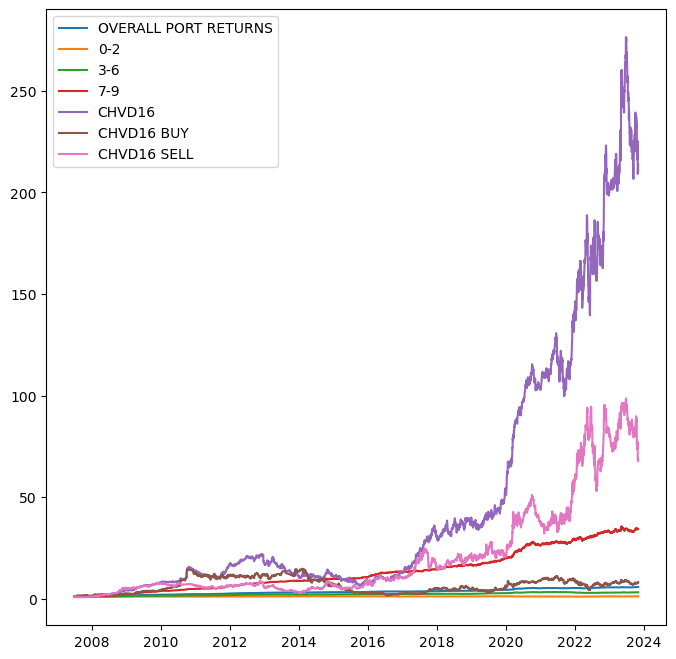

In [12]:
#Overall
def printstats(lbl,drets):
    alpha = drets.mean()
    std = drets.std()
    stdneg = drets[drets<0].std()
    stdpos = drets[drets>=0].std()
    sharpe = alpha/std
    sortino = alpha/stdneg
    
    print(f'{lbl} ALPHA {alpha*10000:.2f} bps, CNT {len(drets):.0f} STD { std*10000:.2f} STD- { stdneg*10000:.2f}bps STD+ { stdneg*10000:.2f}bps sharpe { sharpe:.2f} sortino { sortino:.2f}' )
drets = sim.groupby('date')['ew_return'].mean()
printstats('OVERALL', drets)
for ts in sim['predicted_tstat_q'].unique():
    drets = sim[sim.predicted_tstat_q==ts].groupby('date')['ew_return'].mean()
    printstats(f'TS={ts}',drets)


fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,1,2],[3,4,5,6],[7,8,9]]
for grp in grps:
    pass
    pi = (1+sim[sim.predicted_tstat_q.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')

#for th in [50,70,90]:
#    combo = (1+sim[(sim.TS.astype(float)>=th) & (sim.arvol_quantile.astype(float)>=th)].groupby('date')['ew_return'].mean()).cumprod()
#    plt.plot(combo,label= f'CHV{th}')

for th in [16]: #[80,100,120,160]:
    combo = (1+sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(combo,label= f'CHVD{th}')
#Conviction Hi Vol Diagonal 160 decomposed into buys and sells
th=16
chvdb = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn>0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvdb,label= f'CHVD{th} BUY')
chvds = (1+sim[((sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=th) & (sim.predicted_c2cdn<0)].groupby('date')['ew_return'].mean()).cumprod()
plt.plot(chvds,label= f'CHVD{th} SELL')


plt.legend()
plt.show()

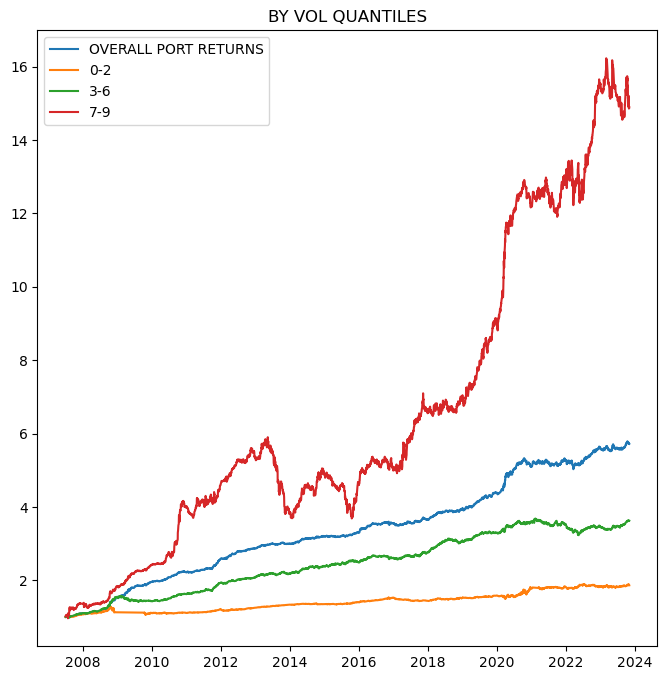

In [13]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot(portRets,label='OVERALL PORT RETURNS')
grps = [[0,1,2],[3,4,5,6],[7,8,9]]
for grp in grps:
    pi = (1+sim[sim.ar_vol_q.isin([(str(g)) for g in grp])].groupby('date')['ew_return'].mean()).cumprod()
    plt.plot(pi,label= f'{min(grp)}-{max(grp)}')
plt.legend()
plt.title('BY VOL QUANTILES')
plt.show()

In [14]:
def sharpes(s):
    sh = s.mean()/s.std()
    so = s.mean()/s[s<0].std()
    return sh,so
    
#hiconv trades
grps = [[],[0,1,2],[3,4,5,6,7,8,9],[3,4,5,6],[7,8,9],[9]]
for grp in grps:
    hc = sim[sim.ar_vol_q.isin([(str(g)) for g in grp])] if len(grp) else sim
    print(f'\nGroup {grp} len {len(hc)}')
          
    #hc = sim[sim.TS.isin(['70','80','90'])]
    #winners/losers by trade
    print(f'By trade winners - {len(hc[hc.ew_return>0])} losers {len(hc[hc.ew_return<0])} ')
    bysym = hc.groupby(hc.sym)['ew_return'].mean()
    print(f'By sym winners - {len(bysym[bysym>0])} losers {len(bysym[bysym<0])} ')
    
    bydate = hc.groupby(hc.date)['ew_return'].mean()
    bydatedf = bydate.reset_index()
    print(f'By date winners - {len(bydate[bydate>0])} losers {len(bydate[bydate<0])} sharpe/sort {sharpes(bydate)}')
    #bymonth = hc.groupby(hc.date.dt.to_period("M"))['ew_return'].mean()
    bymonth = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('M'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By bymonth winners - {len(bymonth[bymonth>0])} losers {len(bymonth[bymonth<0])} sharpe/sort {sharpes(bymonth)}')
    #byq = hc.groupby(hc.date.dt.to_period("Q"))['ew_return'].mean()
    byq = bydatedf.reset_index().groupby(bydatedf.date.dt.to_period('Q'))['ew_return'].apply(lambda g: (1+g).cumprod().to_list()[-1]-1)
    print(f'By byq winners - {len(byq[byq>0])} losers {len(byq[byq<0])} sharpe/sort {sharpes(byq)}')



Group [] len 988770
By trade winners - 503618 losers 485096 
By sym winners - 2592 losers 2101 
By date winners - 2336 losers 1777 sharpe/sort (0.15632428761496928, 0.25202811325667596)
By bymonth winners - 147 losers 49 sharpe/sort (0.6198938526813295, 1.8473979655341288)
By byq winners - 57 losers 9 sharpe/sort (0.7772959619011871, 3.3945980003714924)

Group [0, 1, 2] len 296631
By trade winners - 150385 losers 146229 
By sym winners - 1133 losers 1084 
By date winners - 2070 losers 1785 sharpe/sort (0.04772279097294659, 0.05472221030682955)
By bymonth winners - 128 losers 57 sharpe/sort (0.24348680415261284, 0.2328904972576232)
By byq winners - 43 losers 20 sharpe/sort (0.38519007972890196, 0.537067225392928)

Group [3, 4, 5, 6, 7, 8, 9] len 692139
By trade winners - 353233 losers 338867 
By sym winners - 2446 losers 2032 
By date winners - 2327 losers 1786 sharpe/sort (0.1472873176407153, 0.24083501899770943)
By bymonth winners - 140 losers 56 sharpe/sort (0.6090807277898891, 1.71

     ew_return                      
          mean    std    len std_err
date                                
1       0.0005 0.0276  30490  0.0002
2       0.0005 0.0260  32259  0.0001
3       0.0003 0.0282  32032  0.0002
4       0.0000 0.0257  30388  0.0001
5       0.0005 0.0265  31792  0.0001
6       0.0003 0.0272  33036  0.0001
7       0.0003 0.0248  32749  0.0001
8       0.0003 0.0274  33741  0.0001
9       0.0005 0.0276  33981  0.0001
10      0.0009 0.0298  32986  0.0002
11      0.0006 0.0252  33480  0.0001
12      0.0005 0.0242  33130  0.0001
13      0.0007 0.0259  33812  0.0001
14      0.0008 0.0234  33510  0.0001
15      0.0005 0.0235  32654  0.0001
16      0.0004 0.0246  32619  0.0001
17      0.0002 0.0257  32891  0.0001
18      0.0002 0.0278  31848  0.0002
19      0.0006 0.0271  31949  0.0002
20      0.0004 0.0253  32314  0.0001
21      0.0008 0.0241  32311  0.0001
22      0.0006 0.0239  32808  0.0001
23      0.0003 0.0245  33696  0.0001
24      0.0004 0.0257  32670  0.0001
2

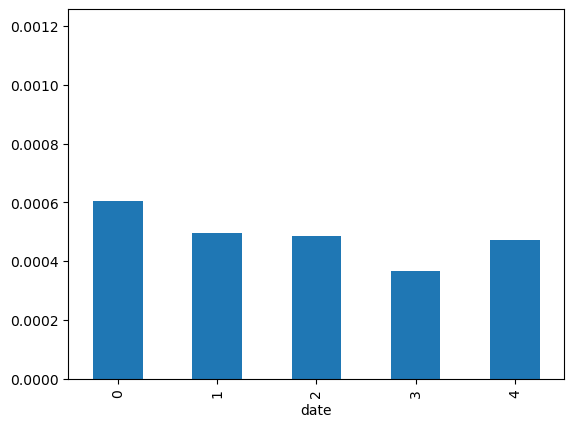

In [15]:
#Is there a day of month effect ( which could be because we recalbrate monthly )
bydayOfMonth = sim.groupby(sim['date'].dt.day).agg({'ew_return':[np.mean,np.std,len]})
bydayOfMonth[('ew_return','std_err')] = bydayOfMonth[('ew_return','std')]/np.sqrt(bydayOfMonth[('ew_return','len')])
bydayOfWeek = sim.groupby(sim['date'].dt.dayofweek).agg({'ew_return':[np.mean,np.std,len]})
bydayOfWeek[('ew_return','std_err')] = bydayOfWeek[('ew_return','std')]/np.sqrt(bydayOfWeek[('ew_return','len')])

with pd.option_context('display.float_format', '{:,.4f}'.format):
    print(bydayOfMonth)
    print(bydayOfWeek)

print(bydayOfMonth[('ew_return','mean')].plot.bar())
print(bydayOfWeek[('ew_return','mean')].plot.bar())


In [16]:
### Dynamic notional allocation scheme that takes into account predicted_tstat_q, ar_vol_q and beta to allocate dollars by trade
def getAllocationWeights(mults:np.ndarray):
    tstatMultipliers,volMultipliers,betaMultipliers,advdMultipliers,abspMultipliers = \
        mults[0:10],mults[10:20],mults[20:30],mults[30:40],mults[40:50]
    PREDICTED_TSTAT_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],tstatMultipliers))
    AR_VOL_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)],  volMultipliers))
    AR_BETA_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], betaMultipliers))
    ADVD_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], advdMultipliers))
    ABS_PRED_Q_MULTIPLIER = dict(zip([str(x) for x in range(10)], abspMultipliers))
    t1 = sim['predicted_tstat_q'].map(PREDICTED_TSTAT_Q_MULTIPLIER).astype(float)
    t2 = sim['ar_vol_q'].map(AR_VOL_Q_MULTIPLIER).astype(float)
    t3 = sim['ar_beta_q'].map(AR_BETA_Q_MULTIPLIER).astype(float)
    t4 = sim['ADVD_q'].map(ADVD_Q_MULTIPLIER).astype(float)
    t5 = sim['abs_predicted_c2cdn_q'].map(ABS_PRED_Q_MULTIPLIER).astype(float)
    score = t1*t2*t3*t5*t5
    dailyScore = score.groupby(sim.date).sum()
    dailyScore.name='dailyScore'
    allocationWeight=score/sim.merge(dailyScore, on='date',how='left')['dailyScore']
    return allocationWeight
    
GLOBAL_COUNTER=0
def getSortino(mults:np.ndarray,verbose=False)->int:
    #print(f'Invoked with {mults}')
    global GLOBAL_COUNTER
    allocationWeight = getAllocationWeights(mults)
    dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
    sortino =  dynamicReturns.mean()/dynamicReturns[dynamicReturns<0].std() #sortino
    sharpe =  dynamicReturns.mean()/dynamicReturns.std() #sharpe
    if verbose or GLOBAL_COUNTER % 100 == 0:
        print( f'{GLOBAL_COUNTER} ALPHA { 10000*dynamicReturns.mean():.2f}bps SORTINO {sortino:.4f} SHARPE {sharpe:.4f}' )
    GLOBAL_COUNTER+=1
    return sortino
        
def getSortinoInverse(mults)->int:
    return 1./getSortino(mults)
    

In [17]:
#getSharpe([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4.],[ .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
#getSharpe(np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.]))
from scipy.optimize import minimize
#initialGuess = np.array([ .2,.2,.2,.2,.2,.5,1.,2.,3.,4., .2,.2,.2,.2,1.,1.,1.,1.,2.,4.])
initialGuess = np.array([.1]*50)
bounds = [(0,None) for v in initialGuess]
GLOBAL_COUNTER=0
solution = minimize(getSortinoInverse,tol=0.0001,x0=initialGuess,bounds=bounds,options={'disp':True, 'maxiter':10000})
mults = solution.x
print('TSTAT VOL BETA ADV APRED')
for i in range(10):
    print(f'{mults[i]:.2f} {mults[i+10]:.2f} {mults[i+20]:.2f} {mults[i+30]:.2f} {mults[i+40]:.2f}')


0 ALPHA 4.28bps SORTINO 0.2520 SHARPE 0.1563
100 ALPHA 15.36bps SORTINO 0.2324 SHARPE 0.1431
200 ALPHA 11.13bps SORTINO 0.2977 SHARPE 0.1741
300 ALPHA 9.08bps SORTINO 0.3284 SHARPE 0.1916
400 ALPHA 8.74bps SORTINO 0.3357 SHARPE 0.1958
500 ALPHA 9.01bps SORTINO 0.3391 SHARPE 0.1967
600 ALPHA 9.32bps SORTINO 0.3413 SHARPE 0.1972
700 ALPHA 9.39bps SORTINO 0.3435 SHARPE 0.1981
800 ALPHA 9.53bps SORTINO 0.3454 SHARPE 0.1984
900 ALPHA 9.53bps SORTINO 0.3470 SHARPE 0.1977
1000 ALPHA 9.40bps SORTINO 0.3490 SHARPE 0.1968
1100 ALPHA 9.32bps SORTINO 0.3520 SHARPE 0.1980
1200 ALPHA 9.08bps SORTINO 0.3529 SHARPE 0.1979
1300 ALPHA 9.10bps SORTINO 0.3554 SHARPE 0.1972
1400 ALPHA 9.17bps SORTINO 0.3556 SHARPE 0.1977
1500 ALPHA 9.20bps SORTINO 0.3569 SHARPE 0.1971
1600 ALPHA 9.23bps SORTINO 0.3580 SHARPE 0.1968
1700 ALPHA 9.27bps SORTINO 0.3583 SHARPE 0.1964
1800 ALPHA 9.16bps SORTINO 0.3589 SHARPE 0.1968
1900 ALPHA 9.14bps SORTINO 0.3592 SHARPE 0.1964
TSTAT VOL BETA ADV APRED
0.02 0.03 0.20 0.10 0.08


In [18]:
allocationWeight = getAllocationWeights(solution.x)
dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
#multDR = (1+dynamicReturns)
#multDR.groupby([multDR.index.year,multDR.index.month]).prod().apply([np.mean,np.std])
annualized = dynamicReturns.groupby([dynamicReturns.index.year]).sum() ## No re-investment / compounding
annualized.mean()/annualized.std()


1.584578440904412

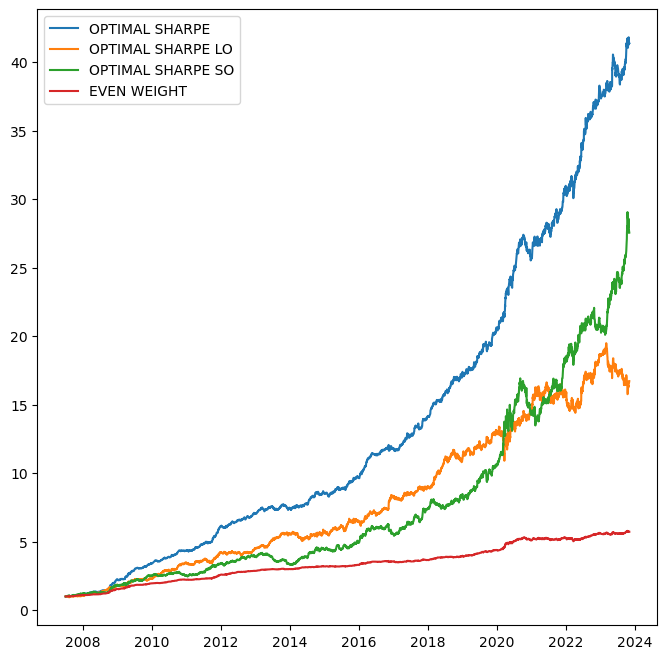

In [19]:
allocationWeight = getAllocationWeights(solution.x)
allocationWeightLO = allocationWeight[np.sign(sim.predicted_c2cdn)==1]
allocationWeightLO=allocationWeightLO/allocationWeightLO.groupby(sim.date).transform(sum)

allocationWeightSO = allocationWeight[np.sign(sim.predicted_c2cdn)==-1]
allocationWeightSO=allocationWeightSO/allocationWeightSO.groupby(sim.date).transform(sum)

dynamicReturns = (allocationWeight*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsLO = (allocationWeightLO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()
dynamicReturnsSO = (allocationWeightSO*sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).sum()


simpleReturns = (sim.c2cdn*np.sign(sim.predicted_c2cdn)).groupby(sim.date).mean()
fig, ax1 = plt.subplots(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
portRets=(1+sim.groupby('date')['ew_return'].mean()).cumprod()
plt.plot((1+dynamicReturns).cumprod(),label='OPTIMAL SHARPE')
plt.plot((1+dynamicReturnsLO).cumprod(),label='OPTIMAL SHARPE LO')
plt.plot((1+dynamicReturnsSO).cumprod(),label='OPTIMAL SHARPE SO')
plt.plot((1+simpleReturns).cumprod(),label='EVEN WEIGHT')
#High rish strategy
hiRiskTrades = sim[(sim.predicted_tstat_q.astype(float)+sim.ar_vol_q.astype(float))>=16]
hiRiskReturns = hiRiskTrades.groupby('date')['ew_return'].mean()
#plt.plot((1+hiRiskReturns).cumprod(),label='HI RISK')

plt.legend()
plt.show()

In [20]:
with pd.option_context('display.max_columns', 50):
    display(sim.head())


,Unnamed: 0.1,Unnamed: 0,date,sym,adjusted_close,o2c,volume,prev_c2c,c2c,prev_volume,benchmark,c2cb,o2cb,prev_c2cb,c2cdn,prev_c2cdn,o2cdn,predicted_c2cdn,predicted_se,model_order,ar_vol,ar_beta,ADV,ADVD,ew_return,ewo_return,P,Q,predicted_tstat,abs_predicted_c2cdn,strategy,activity,predicted_tstat_q,ar_beta_q,ar_vol_q,ADV_q,ADVD_q,abs_predicted_c2cdn_q,activity_q
0,0,0,2007-07-02,ABBC,9.64,-0.011282,242400.0,-0.005208,0.009424,638700.0,SPY,0.009041,0.006098,0.000332,0.000383,-0.005540,-0.017380,-0.001681,0.011965,"(1, 0, 1)",0.018646,0.839000,49440.0,511699.70,-0.000383,0.017380,1,1,0.140495,0.001681,MS,12.918689,4,2,2,1,1,3,9
1,1,1,2007-07-03,ABBC,9.69,-0.008188,126300.0,0.009424,0.005187,242400.0,SPY,0.003623,0.001051,0.009041,0.001564,0.000383,-0.009240,-0.002958,0.011965,"(1, 0, 1)",0.018601,0.837517,49600.0,529947.40,-0.001564,0.009240,1,1,0.247221,0.002958,RS,4.887097,6,2,2,1,1,5,9
2,2,2,2007-07-05,ABBC,9.84,0.016529,171400.0,0.005187,0.015480,126300.0,SPY,-0.001050,-0.001444,0.003623,0.016530,0.001564,0.017972,-0.003203,0.011965,"(1, 0, 1)",0.018603,0.840805,51360.0,539102.44,-0.016530,-0.017972,1,1,0.267702,0.003203,RS,2.459112,7,2,2,1,1,5,9
3,3,3,2007-07-06,ABBC,9.89,0.007128,285800.0,0.015480,0.005081,171400.0,SPY,0.005257,0.003937,-0.001050,-0.000176,0.016530,0.003191,-0.006087,0.011965,"(1, 0, 1)",0.018575,0.834053,58080.0,646140.00,0.000176,-0.003191,1,1,0.508740,0.006087,RS,2.951102,9,2,2,1,1,7,9
4,4,4,2007-07-09,ABBC,9.76,-0.005097,182300.0,0.005081,-0.013145,285800.0,SPY,0.000131,-0.001045,0.005257,-0.013275,-0.000176,-0.004052,-0.002912,0.011965,"(1, 0, 1)",0.018587,0.837072,62080.0,684432.00,0.013275,0.004052,1,1,0.243362,0.002912,MS,4.603737,6,2,2,1,1,5,9


In [21]:
allocationWeight = getAllocationWeights(solution.x)

bySim = (np.sign(sim.predicted_c2cdn) * sim.c2cdn).groupby([sim.sym,sim.date.dt.year]).agg( samples=len,rtrn=np.mean )
bySim.sort_values('rtrn',inplace=True)
bySim.to_csv('c:/temp/bysim.csv')

